# Import libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

# Data Import

In [2]:
dataset = pd.read_csv("Desktop/diabetes.csv")

##### Optional Drop Column

In [3]:
# Remove the column you want to drop
#column_to_drop = "ID"  # Replace "column_name" with the name of the column you want to remove
#dataset.drop(columns=[column_to_drop], inplace=True)

# Data Cleaning

In [4]:
dataset.info()
#Distribution
dataset.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### Null Values

In [5]:
dataset.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
# Calculate the threshold for missing values
threshold = 0.2 * len(dataset)

# Iterate over each column
for column in dataset.columns:
    # Check if the column has missing values
    if dataset[column].isna().sum() > 0:
        # If the column is numerical, fill missing values with column mean
        if dataset[column].dtype in ['int64', 'float64']:
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])
            # If the number of missing values is greater than or equal to the threshold, fill with column mean
            else:
                column_mean = dataset[column].mean()
                dataset[column].fillna(column_mean, inplace=True)
        # If the column is categorical, drop rows with missing values
        elif dataset[column].dtype == 'object':
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])

# Print modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())


Modified Dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [7]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")


## Identify Target Variable

In [10]:
target = 'Outcome'

# Feature Engineering 

In [11]:
# Convert the "sales" column to string type if it's not already
#dataset['sales'] = dataset['sales'].astype(str)

# Remove dollar signs and commas, and convert to integers
#dataset['sales'] = dataset['sales'].str.replace('$', '').str.replace(',', '', regex=False).astype(int)


### One Hot Encoder

In [12]:
# Check for categorical variables
categorical_columns = set()

# Add columns with less than 10 unique values
for column in dataset.columns:
    if column != target and dataset[column].nunique() < 10:
        categorical_columns.add(column)

# Append columns with object data type
categorical_columns.update(col for col in dataset.select_dtypes(include=['object']).columns.tolist() if col != target and col != target)

# Identify and add true/false columns
true_false_columns = [col for col in dataset.columns if dataset[col].dtype == 'bool']
categorical_columns.update(true_false_columns)

if len(categorical_columns) > 0:
    print("Categorical columns found:")
    for column in categorical_columns:
        print(column)
    
    # Fit the encoder to the categorical columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_columns = encoder.fit_transform(dataset[list(categorical_columns)])

    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(input_features=list(categorical_columns))

    # Create a DataFrame with the encoded columns and feature names
    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names, index=dataset.index)

    # Drop original categorical columns
    dataset.drop(columns=categorical_columns, inplace=True)
    
    # Concatenate encoded columns with dataset
    dataset = pd.concat([dataset, encoded_df], axis=1)
    
# Display the modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())

Modified Dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [13]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")

### Binary Variables

In [14]:
binary_variables = []

# Iterate through each column
for column in dataset.columns:
    # Check if the number of unique values is 2 and values are 0 and 1, or if the value is just 0
    if (dataset[column].nunique() == 2 and set(dataset[column]) == {0, 1}) or (dataset[column].nunique() == 1 and set(dataset[column]) == {0}):
        binary_variables.append(column)

# Print binary variables
print("Binary Variables:")
print(binary_variables)

Binary Variables:
['Outcome']


## Numerical to Binary Variables

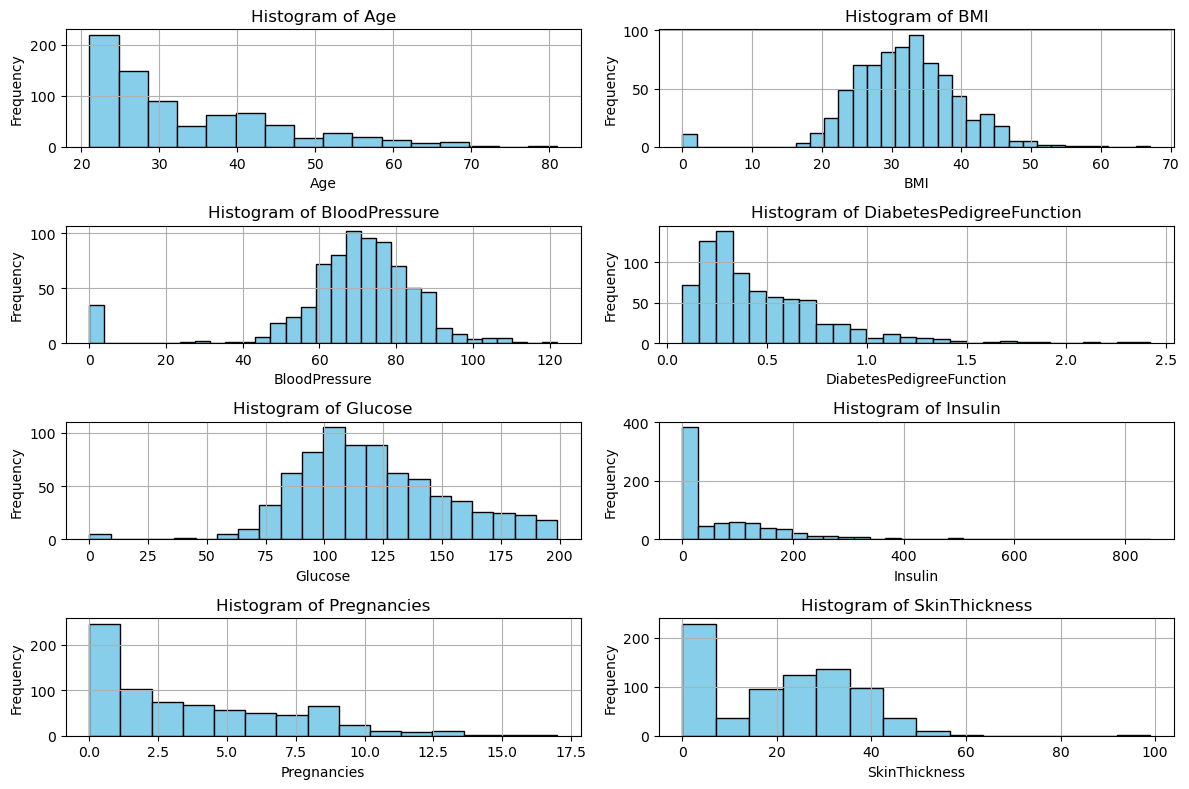

In [15]:
# Check if the target variable is numerical or categorical
if dataset[target].dtype in ['int64', 'float64']:
    # Get numerical variables excluding the target variable
    numerical_variables = dataset.select_dtypes(include=['int64', 'float64']).columns.drop(target)
else:
    # Get numerical variables excluding the target variable
    numerical_variables = dataset.select_dtypes(include=['int64', 'float64']).columns

numerical_variables = numerical_variables.difference(binary_variables)

# Calculate number of bins for each numerical variable
num_bins_dict = {}
for column in numerical_variables:
    # Calculate the number of bins using Freedman-Diaconis rule
    q75, q25 = dataset[column].quantile([0.75, 0.25])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(dataset[column]) ** (1/3))
    
    # Check if bin_width is zero
    if bin_width == 0:
        # Set a default number of bins or handle it appropriately
        num_bins = 10  # Default value
    else:
        num_bins = int((dataset[column].max() - dataset[column].min()) / bin_width)
        
    # Ensure num_bins is an integer value
    num_bins = int(num_bins)
    
    num_bins_dict[column] = num_bins

# Initialize an empty DataFrame to store the binned categorical variables
binned_dataset = pd.DataFrame()

# Calculate the number of rows and columns for subplots
num_variables = len(numerical_variables)
num_rows = int(np.ceil(num_variables / 2))
num_cols = 2

# Initialize figure for histograms
plt.figure(figsize=(12, 8))

# Iterate through each numerical variable
for i, column in enumerate(numerical_variables):
    plt.subplot(num_rows, num_cols, i + 1)
    
    # Plot histogram
    plt.hist(dataset[column], bins=num_bins_dict[column], color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.grid(True)
    
# Display the histograms
plt.tight_layout()
plt.show()

In [16]:
# Initialize an empty DataFrame to store the binned categorical variables
binned_dataset = pd.DataFrame()

# Iterate through each numerical variable
for column in numerical_variables:
    # Calculate the maximum number of bins for this column
    max_bins_column = num_bins_dict[column]
    
    # Bin the data accordingly
    bins, bin_edges = pd.cut(dataset[column], bins=max_bins_column, retbins=True)
    
    # Generate bin labels from the bin edges
    bin_labels = [f"{column}_{int(bin_edges[i])}_{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
    
    # Encode bins using one-hot encoding
    encoded_bins = pd.get_dummies(bins, prefix=column)
    
    # Rename columns with integer bin edges
    encoded_bins.columns = bin_labels
    
    # Concatenate encoded bins to the binned dataset
    binned_dataset = pd.concat([binned_dataset, encoded_bins], axis=1)

# Display the first few rows of the binned dataset
print("Binned Dataset:")
print(binned_dataset.head())



Binned Dataset:
   Age_20_24  Age_24_28  Age_28_32  Age_32_36  Age_36_39  Age_39_43  \
0          0          0          0          0          0          0   
1          0          0          1          0          0          0   
2          0          0          1          0          0          0   
3          1          0          0          0          0          0   
4          0          0          0          1          0          0   

   Age_43_47  Age_47_51  Age_51_54  Age_54_58  ...  SkinThickness_28_35  \
0          0          1          0          0  ...                    1   
1          0          0          0          0  ...                    1   
2          0          0          0          0  ...                    0   
3          0          0          0          0  ...                    0   
4          0          0          0          0  ...                    1   

   SkinThickness_35_42  SkinThickness_42_49  SkinThickness_49_56  \
0                    0                

In [17]:
# Check for duplicate column names
duplicate_columns = binned_dataset.columns[binned_dataset.columns.duplicated()]

# Print duplicate column names, if any
if len(duplicate_columns) > 0:
    print("Duplicate column names found:")
    for column in duplicate_columns:
        print(column)
    
    # Merge duplicate columns
    binned_dataset = binned_dataset.groupby(level=0, axis=1).sum()
    
    print("Duplicate columns merged.")
else:
    print("No duplicate column names found.")

Duplicate column names found:
DiabetesPedigreeFunction_0_0
DiabetesPedigreeFunction_0_0
DiabetesPedigreeFunction_0_0
DiabetesPedigreeFunction_0_0
DiabetesPedigreeFunction_0_0
DiabetesPedigreeFunction_0_0
DiabetesPedigreeFunction_0_0
DiabetesPedigreeFunction_0_0
DiabetesPedigreeFunction_0_0
DiabetesPedigreeFunction_0_0
DiabetesPedigreeFunction_1_1
DiabetesPedigreeFunction_1_1
DiabetesPedigreeFunction_1_1
DiabetesPedigreeFunction_1_1
DiabetesPedigreeFunction_1_1
DiabetesPedigreeFunction_1_1
DiabetesPedigreeFunction_1_1
DiabetesPedigreeFunction_1_1
DiabetesPedigreeFunction_1_1
DiabetesPedigreeFunction_2_2
DiabetesPedigreeFunction_2_2
DiabetesPedigreeFunction_2_2
DiabetesPedigreeFunction_2_2
Duplicate columns merged.


In [18]:
# Drop numerical columns from the original dataset
dataset.drop(columns=numerical_variables, inplace=True)

# Concatenate binned_dataset with the original dataset
dataset = pd.concat([dataset, binned_dataset], axis=1)

# Display the updated dataset
print("Updated Dataset:")
print(dataset.head())

Updated Dataset:
   Outcome  Age_20_24  Age_24_28  Age_28_32  Age_32_36  Age_36_39  Age_39_43  \
0        1          0          0          0          0          0          0   
1        0          0          0          1          0          0          0   
2        1          0          0          1          0          0          0   
3        0          1          0          0          0          0          0   
4        1          0          0          0          1          0          0   

   Age_43_47  Age_47_51  Age_51_54  ...  SkinThickness_35_42  \
0          0          1          0  ...                    0   
1          0          0          0  ...                    0   
2          0          0          0  ...                    0   
3          0          0          0  ...                    0   
4          0          0          0  ...                    0   

   SkinThickness_42_49  SkinThickness_49_56  SkinThickness_56_63  \
0                    0                    0      

In [19]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")

### Up-Sampling

##### Outcome

In [20]:
dataset.groupby(target).count()

,Age_20_24,Age_24_28,Age_28_32,Age_32_36,Age_36_39,Age_39_43,Age_43_47,Age_47_51,Age_51_54,Age_54_58,...,SkinThickness_35_42,SkinThickness_42_49,SkinThickness_49_56,SkinThickness_56_63,SkinThickness_63_70,SkinThickness_70_77,SkinThickness_77_84,SkinThickness_7_14,SkinThickness_84_91,SkinThickness_91_99
Outcome,,,,,,,,,,,,,,,,,,,,,
0,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500
1,268,268,268,268,268,268,268,268,268,268,...,268,268,268,268,268,268,268,268,268,268


Target Value Counts (Sorted):
0    500
1    268
Name: Outcome, dtype: int64


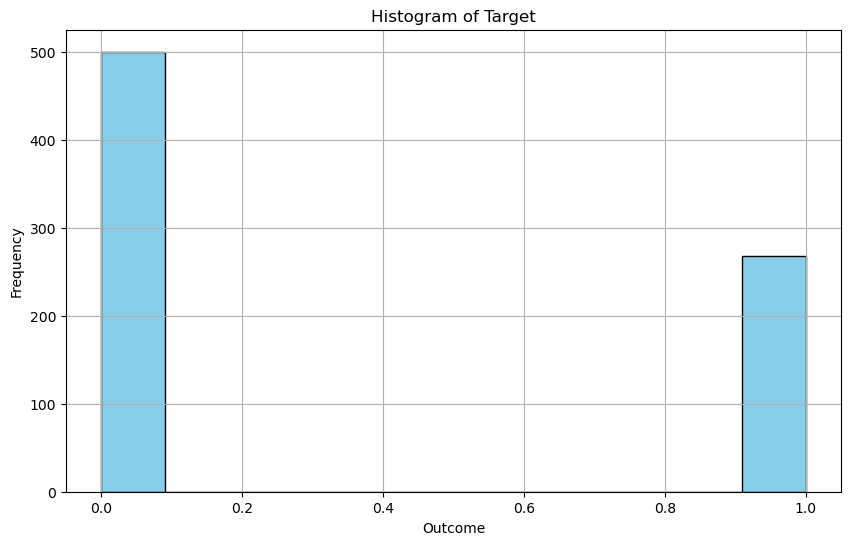

In [21]:
target_counts_sorted = dataset[target].value_counts().sort_index()

# Display the counts
print("Target Value Counts (Sorted):")
print(target_counts_sorted)

plt.figure(figsize=(10, 6))
plt.hist(dataset[target], bins='auto', color='skyblue', edgecolor='black')
plt.xlabel(target)
plt.ylabel('Frequency')
plt.title('Histogram of Target')
plt.grid(True)
plt.show()

In [22]:

df_majority = dataset[dataset[target] == 0]


df_minority = dataset[dataset[target] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),
                                 random_state=42)  # Add random_state for reproducibility

# Combine minority class with majority class
dataset = pd.concat([df_majority, df_minority_upsampled])

# Check the value counts of the prediction column in the downsampled dataset
print(dataset[target].value_counts())


0    500
1    500
Name: Outcome, dtype: int64


### Bias in other features

In [24]:
# Iterate over columns starting with "X"
for column in dataset.columns:
    if column.startswith("Age"):
        # Get the target column
        upsamp_target = dataset[column]
        
        # Get the sorted value counts
        target_counts_sorted = upsamp_target.value_counts().sort_index()

        # Display the counts
        print(f"Target Value Counts for {column} (Sorted):")
        print(target_counts_sorted)

Target Value Counts for Age_20_24 (Sorted):
0    754
1    246
Name: Age_20_24, dtype: int64
Target Value Counts for Age_24_28 (Sorted):
0    823
1    177
Name: Age_24_28, dtype: int64
Target Value Counts for Age_28_32 (Sorted):
0    877
1    123
Name: Age_28_32, dtype: int64
Target Value Counts for Age_32_36 (Sorted):
0    922
1     78
Name: Age_32_36, dtype: int64
Target Value Counts for Age_36_39 (Sorted):
0    928
1     72
Name: Age_36_39, dtype: int64
Target Value Counts for Age_39_43 (Sorted):
0    905
1     95
Name: Age_39_43, dtype: int64
Target Value Counts for Age_43_47 (Sorted):
0    939
1     61
Name: Age_43_47, dtype: int64
Target Value Counts for Age_47_51 (Sorted):
0    949
1     51
Name: Age_47_51, dtype: int64
Target Value Counts for Age_51_54 (Sorted):
0    969
1     31
Name: Age_51_54, dtype: int64
Target Value Counts for Age_54_58 (Sorted):
0    972
1     28
Name: Age_54_58, dtype: int64
Target Value Counts for Age_58_62 (Sorted):
0    984
1     16
Name: Age_58_62, d

In [ ]:
# Select rows where the value in the target column is equal to 1
df_majority = dataset[dataset["Gender_Male"] == 1]


# Select rows where the value in the target column is equal to 0
df_minority = dataset[dataset["Gender_Male"] == 0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),
                                 random_state=42)  # Add random_state for reproducibility

# Combine minority class with majority class
dataset = pd.concat([df_majority, df_minority_upsampled])

# Check the value counts of the prediction column in the downsampled dataset
print(dataset["Gender_Male"].value_counts())

# Dimensionality Reduction

In [25]:
#Check for perfect multicollinearity
correlation_matrix = dataset.corr()
highly_correlated_variables = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_variables.add(colname_i)
            highly_correlated_variables.add(colname_j)
print("Highly correlated variables:", highly_correlated_variables)

# Step 2: Remove constant variables
constant_variables = [col for col in dataset.columns if dataset[col].nunique() == 1]
print("Constant variables:", constant_variables)
dataset.drop(columns=constant_variables, inplace=True)

# Define the target variable 'y'
y = dataset[target]

# Select all other columns as features 'x'
x = dataset.drop(columns=[target])

Highly correlated variables: {'BloodPressure_27_31', 'BMI_54_56', 'DiabetesPedigreeFunction_0_0', 'BMI_50_52', 'Insulin_676_705', 'DiabetesPedigreeFunction_1_1'}
Constant variables: ['Age_73_77', 'BMI_10_12', 'BMI_12_14', 'BMI_14_16', 'BMI_2_4', 'BMI_4_6', 'BMI_61_63', 'BMI_63_65', 'BMI_6_8', 'BMI_8_10', 'BloodPressure_114_118', 'BloodPressure_11_15', 'BloodPressure_15_19', 'BloodPressure_19_23', 'BloodPressure_31_35', 'BloodPressure_39_43', 'BloodPressure_3_7', 'BloodPressure_7_11', 'DiabetesPedigreeFunction_1_2', 'Glucose_18_27', 'Glucose_27_36', 'Glucose_45_54', 'Glucose_9_18', 'Insulin_620_648', 'Insulin_648_676', 'Insulin_705_733', 'Insulin_761_789', 'Insulin_789_817', 'Insulin_817_846', 'SkinThickness_63_70', 'SkinThickness_70_77', 'SkinThickness_77_84', 'SkinThickness_84_91', 'SkinThickness_91_99']


### Outlier Detection

#### **Data is scaled in this step***

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Perform KMeans clustering
# Separate features (X) and target variable (y) if necessary
X = dataset.drop(columns=[target])
y = dataset[target]

# Scale the features (X)
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

kmeans = KMeans()
kmeans.fit(scaled_X)

# Get cluster centers
centers = kmeans.cluster_centers_

# Calculate distances of each point to its respective cluster center
distances = np.sqrt(np.sum((scaled_X - centers[kmeans.labels_])**2, axis=1))

# Calculate mean and standard deviation of distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Desired threshold as 2 standard deviations from the mean
desired_threshold = mean_distance + 2 * std_distance

# Use the threshold for outlier detection
outliers_mask = distances > desired_threshold

# Save outliers in a new dataset
outliers_dataset = dataset[outliers_mask]

# Print indices and details of outliers
print("Indices of outliers:", np.where(outliers_mask)[0])
print("Details of outliers:")
print(outliers_dataset)

# Remove outliers from the original dataset
dataset = dataset[~outliers_mask]

Indices of outliers: [  6  30  34  68 151 152 160 243 257 271 280 284 338 348 390 391 425 442
 551 569 599 607 608 618 731 732 734 748 786 792 808 809 813 820 844 846
 853 933 952 972 986]
Details of outliers:
     Outcome  Age_20_24  Age_24_28  Age_28_32  Age_32_36  Age_36_39  \
18         0          0          0          0          1          0   
57         0          0          0          1          0          0   
62         0          0          0          0          1          0   
106        0          0          1          0          0          0   
247        0          1          0          0          0          0   
248        0          0          0          0          1          0   
258        0          1          0          0          0          0   
392        0          1          0          0          0          0   
418        0          0          1          0          0          0   
438        0          1          0          0          0          0   
453      

### Principal Component Analysis (PCA)

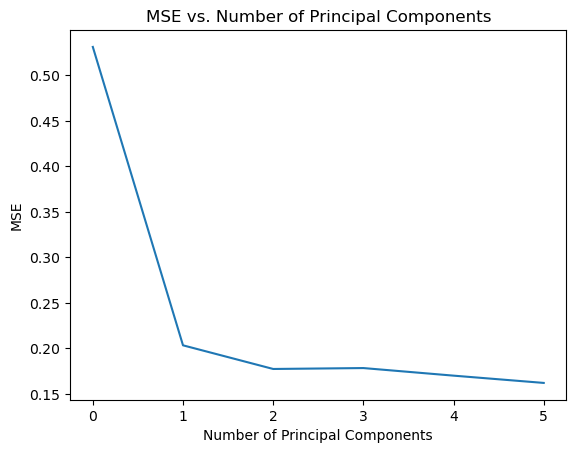

In [27]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest Classifier
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
x_reduced = pca.fit_transform(x)

# Define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Calculate MSE with only the intercept
mse = []
score = -1 * cross_val_score(rf_classifier, np.ones((len(x_reduced), 1)), y, cv=cv, scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1 * cross_val_score(rf_classifier, x_reduced[:, :i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

# Plot cross-validation results
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Principal Components')
plt.show()


In [28]:
#percentage of variance in the response variable explained by adding in each principal component to the model:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([  7.73,  12.84,  16.37,  19.75,  22.77,  25.55,  28.14,  30.67,
        33.11,  35.44,  37.69,  39.84,  41.92,  43.95,  45.91,  47.83,
        49.69,  51.48,  53.17,  54.84,  56.48,  58.09,  59.62,  61.13,
        62.58,  64.02,  65.37,  66.68,  67.93,  69.15,  70.34,  71.5 ,
        72.61,  73.7 ,  74.78,  75.81,  76.79,  77.74,  78.68,  79.6 ,
        80.48,  81.35,  82.18,  83.  ,  83.75,  84.49,  85.22,  85.89,
        86.55,  87.19,  87.81,  88.4 ,  88.97,  89.51,  90.03,  90.54,
        91.04,  91.51,  91.96,  92.39,  92.81,  93.21,  93.6 ,  93.96,
        94.31,  94.64,  94.93,  95.21,  95.48,  95.73,  95.98,  96.21,
        96.42,  96.62,  96.81,  97.  ,  97.18,  97.35,  97.52,  97.68,
        97.82,  97.96,  98.09,  98.21,  98.32,  98.42,  98.52,  98.62,
        98.71,  98.8 ,  98.88,  98.96,  99.04,  99.11,  99.18,  99.25,
        99.32,  99.38,  99.44,  99.5 ,  99.55,  99.6 ,  99.64,  99.68,
        99.71,  99.74,  99.77,  99.8 ,  99.83,  99.85,  99.87,  99.89,
      

In [29]:
# Choose the desired number of principal components based on the plot
num_components = 96 # For example, choose n principal components

# Use the selected number of principal components
x_reduced_selected = x_reduced[:, :num_components]

# Splitting the dataset

In [30]:
from sklearn.model_selection import train_test_split


# Split the data into training (50%), testing (30%), and out-of-sample (20%)
x_train, x_temp, y_train, y_temp = train_test_split(x_reduced_selected, y, test_size=0.4, random_state=100)
x_test, x_out_sample, y_test, y_out_sample = train_test_split(x_temp, y_temp, test_size=0.6, random_state=100)

In [31]:
missing_values = dataset.isnull().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")


# Fitting the Random Forest model

In [32]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV 

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1472b2b90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x146ddd850>})

In [33]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 11, 'n_estimators': 358}


In [34]:
rf_model = RandomForestClassifier(max_depth=11,n_estimators=358)
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=11, n_estimators=358)

In [35]:
y_pred = rf_model.predict(x_test)

In [36]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.81875


# Model Evaluation

### On test data

In [37]:
from sklearn import metrics

# Predict the labels for the test set
y_pred = rf_model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(accuracy))

Accuracy: 81.88%


In [38]:
from sklearn.metrics import balanced_accuracy_score

# Assuming y_true and y_pred are your true and predicted labels, respectively
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)* 100

print('Balanced Accuracy Score: {:.2f}%'.format(balanced_accuracy))

Balanced Accuracy Score: 81.71%


only for binary classification

In [39]:
y_pred_prob_t = rf_model.predict_proba(x_test)

def class_likelihood_ratios(y_test, y_pred_prob_t):
    """
    Calculate class likelihood ratios given true labels and predicted probabilities.

    Parameters:
    y_true (array-like): True labels.
    y_prob (array-like): Predicted probabilities for the positive class.

    Returns:
    class_lr (dict): Dictionary containing class likelihood ratios.
    """
    # Extract unique classes
    classes = np.unique(y_test)
    
    # Initialize dictionary to store likelihood ratios
    class_lr = {}
    
    # Calculate likelihood ratios for each class
    for cls in classes:
        # Calculate class-specific likelihood ratio
        class_prob = y_pred_prob_t[:, cls]
        class_lr[cls] = np.sum(class_prob) / (len(class_prob) - np.sum(class_prob))
    
    return class_lr

In [40]:
# Calculate class likelihood ratios

class_lr = class_likelihood_ratios(y_test, y_pred_prob_t)

# Print class likelihood ratios
print("Class Likelihood Ratios:")
for cls, lr in class_lr.items():
    print(f"Class {cls}: {lr}")

Class Likelihood Ratios:
Class 0: 0.861171076769311
Class 1: 1.1612094588121864


In [41]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, y_pred, average=None)

array([0.7184466, 0.6627907])

### On out-of-sample data

In [42]:
# Predict the labels for the out-of-sample set
y_pred_out_sample = rf_model.predict(x_out_sample)

# Calculate accuracy
accuracy_out_sample = accuracy_score(y_out_sample, y_pred_out_sample) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(accuracy_out_sample))


Accuracy: 83.33%


In [43]:
balanced_accuracy = balanced_accuracy_score(y_out_sample, y_pred_out_sample)*100

print('Balanced Accuracy Score: {:.2f}%'.format(balanced_accuracy))

Balanced Accuracy Score: 83.29%


In [44]:
y_pred_prob_o = rf_model.predict_proba(x_out_sample)

def class_likelihood_ratios(y_out_sample, y_pred_prob_o):
    """
    Calculate class likelihood ratios given true labels and predicted probabilities.

    Parameters:
    y_true (array-like): True labels.
    y_prob (array-like): Predicted probabilities for each class.

    Returns:
    class_lr (dict): Dictionary containing class likelihood ratios.
    """
    # Extract unique classes
    classes = np.unique(y_out_sample)
    
    # Initialize dictionary to store likelihood ratios
    class_lr = {}
    
    # Calculate likelihood ratios for each class
    for cls in classes:
        # Calculate class-specific likelihood ratio
        class_prob = y_pred_prob_o[:, cls]
        class_lr[cls] = np.sum(class_prob) / (len(class_prob) - np.sum(class_prob))
    
    return class_lr

In [45]:
class_lr = class_likelihood_ratios(y_test, y_pred_prob_o)

# Print class likelihood ratios
print("Class Likelihood Ratios:")
for cls, lr in class_lr.items():
    print(f"Class {cls}: {lr}")

Class Likelihood Ratios:
Class 0: 0.807788403772447
Class 1: 1.2379479518768863


In [46]:
from sklearn.metrics import jaccard_score
jaccard_score(y_out_sample, y_pred_out_sample, average=None)

array([0.72413793, 0.7037037 ])

# Confusion Matrix

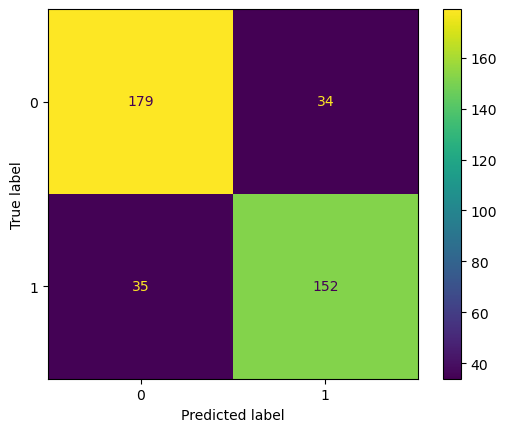

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm_test = confusion_matrix(y_test, y_pred)
cm_out_sample = confusion_matrix(y_out_sample, y_pred_out_sample)

# Combine the confusion matrices
cm = cm_test + cm_out_sample

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [48]:
# Extract indices of false positives and false negatives from the confusion matrix
false_positive_indices = [(i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1]) if i != j and j == 1]  # False positive indices
false_negative_indices = [(i, j) for i in range(cm.shape[0]) for j in range(cm.shape[1]) if i != j and j == 0]  # False negative indices

# Create new DataFrame to store instances with correct and incorrect predictions
correct_rows = []
incorrect_rows = []

for index, (true_label, pred_label, out_true_label, out_pred_label) in enumerate(zip(y_test, y_pred, y_out_sample, y_pred_out_sample)):
    # Check for false positives or false negatives in the first set of predictions
    if (true_label, pred_label) in false_positive_indices or (true_label, pred_label) in false_negative_indices:
        row_data = dataset.iloc[index].tolist()
        incorrect_rows.append(row_data + [False])
    else:
        row_data = dataset.iloc[index].tolist()
        correct_rows.append(row_data + [True])

# Process remaining instances in the second set of predictions
for index, (out_true_label, out_pred_label) in enumerate(zip(y_out_sample, y_pred_out_sample)):
    # Check for false positives or false negatives in the second set of predictions
    if (out_true_label, out_pred_label) in false_positive_indices or (out_true_label, out_pred_label) in false_negative_indices:
        row_data = dataset.iloc[len(y_test) + index].tolist()  # Adjust index to start from where the first loop left off
        incorrect_rows.append(row_data + [False])
    else:
        row_data = dataset.iloc[len(y_test) + index].tolist()  # Adjust index to start from where the first loop left off
        correct_rows.append(row_data + [True])

# Create DataFrames from the collected rows
correct_df = pd.DataFrame(correct_rows, columns=dataset.columns.tolist() + ['correct'])
incorrect_df = pd.DataFrame(incorrect_rows, columns=dataset.columns.tolist() + ['correct'])

# Combine correct_df and incorrect_df into a single DataFrame
result_dataset = pd.concat([correct_df, incorrect_df], ignore_index=True)

# Print the resulting dataset
print(result_dataset)



     Outcome  Age_20_24  Age_24_28  Age_28_32  Age_32_36  Age_36_39  \
0          0          0          0          1          0          0   
1          0          1          0          0          0          0   
2          0          0          0          1          0          0   
3          0          0          0          1          0          0   
4          0          0          0          0          0          0   
..       ...        ...        ...        ...        ...        ...   
395        0          0          0          0          0          0   
396        0          0          0          0          1          0   
397        0          0          0          0          1          0   
398        0          1          0          0          0          0   
399        0          0          0          1          0          0   

     Age_39_43  Age_43_47  Age_47_51  Age_51_54  ...  SkinThickness_0_7  \
0            0          0          0          0  ...                  0 

In [49]:
# Count the number of correct predictions
correct_count = result_dataset[result_dataset['correct'] == True].shape[0]
print (correct_count)

331


### Fairness Test

use this when theres multiple columns youre looking over (ex. age_10_15...age 40_50.. etc)

In [50]:
# Initialize dictionary to store error rates
error_rates = {}

# Iterate over columns in the dataset
for column in result_dataset.columns:
    # Check if the column name starts with "salary"
    if column.startswith('Age'):
        # Filter rows where the current salary column equals 1
        salary_rows = result_dataset[result_dataset[column] == 1]
        # Calculate error rate for the current salary column
        error_rate = 1 - salary_rows['correct'].mean()
        # Store error rate in the dictionary
        error_rates[column] = error_rate

# Print error rates for each salary column
for column, error_rate in error_rates.items():
    print(f"Error rate for rows where {column} = 1 in result_dataset:", error_rate)


Error rate for rows where Age_20_24 = 1 in result_dataset: 0.1854304635761589
Error rate for rows where Age_24_28 = 1 in result_dataset: 0.15476190476190477
Error rate for rows where Age_28_32 = 1 in result_dataset: 0.12195121951219512
Error rate for rows where Age_32_36 = 1 in result_dataset: 0.18181818181818177
Error rate for rows where Age_36_39 = 1 in result_dataset: 0.31999999999999995
Error rate for rows where Age_39_43 = 1 in result_dataset: 0.08695652173913049
Error rate for rows where Age_43_47 = 1 in result_dataset: 0.0714285714285714
Error rate for rows where Age_47_51 = 1 in result_dataset: 0.11111111111111116
Error rate for rows where Age_51_54 = 1 in result_dataset: 0.0
Error rate for rows where Age_54_58 = 1 in result_dataset: 0.36363636363636365
Error rate for rows where Age_58_62 = 1 in result_dataset: 0.0
Error rate for rows where Age_62_66 = 1 in result_dataset: 0.33333333333333337
Error rate for rows where Age_66_69 = 1 in result_dataset: 0.0
Error rate for rows whe

use when looking over one column (ex. Sex_Male)

In [ ]:
# Initialize dictionaries to store error rates
error_rates_1 = {}
error_rates_0 = {}

# Iterate over columns in the dataset
for column in result_dataset.columns:
    # Check if the column name starts with "Sex"
    if column.startswith('Gender'):
        # Filter rows where the current column equals 1
        rows_1 = result_dataset[result_dataset[column] == 1]
        # Calculate error rate for the current column when equal to 1
        error_rate_1 = 1 - rows_1['correct'].mean()
        # Store error rate in the dictionary
        error_rates_1[column] = error_rate_1

        # Filter rows where the current column equals 0
        rows_0 = result_dataset[result_dataset[column] == 0]
        # Calculate error rate for the current column when equal to 0
        error_rate_0 = 1 - rows_0['correct'].mean()
        # Store error rate in the dictionary
        error_rates_0[column] = error_rate_0

# Print error rates for each column where equal to 1
print("Error rates for rows where the column equals 1 in result_dataset:")
for column, error_rate in error_rates_1.items():
    print(f"Error rate for {column}: {error_rate}")

# Print error rates for each column where equal to 0
print("\nError rates for rows where the column equals 0 in result_dataset:")
for column, error_rate in error_rates_0.items():
    print(f"Error rate for {column}: {error_rate}")


# ROC Curve

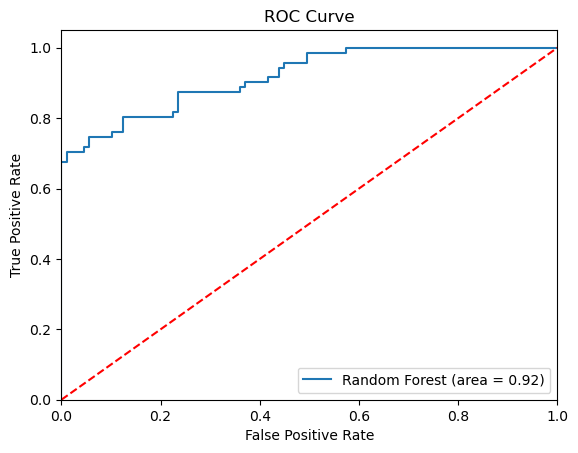

In [51]:
from sklearn.metrics import roc_curve, auc

#Predict probabilities on the test set
y_pred_proba = rf_model.predict_proba(x_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Precision Recall Curve

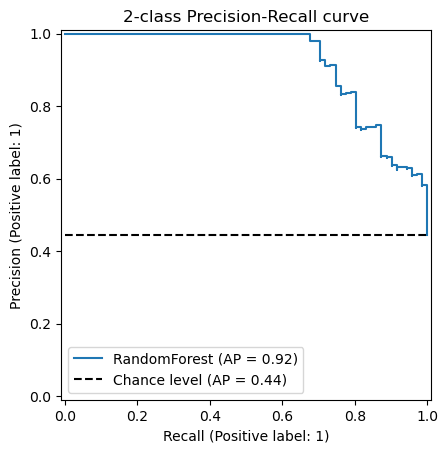

In [52]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Plot Precision-Recall curve with chance level
display = PrecisionRecallDisplay.from_predictions(
    y_test, y_pred_proba, name="RandomForest", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Outlier Model

### Up-Sampling

Target Value Counts (Sorted):
0    18
1    23
Name: Outcome, dtype: int64


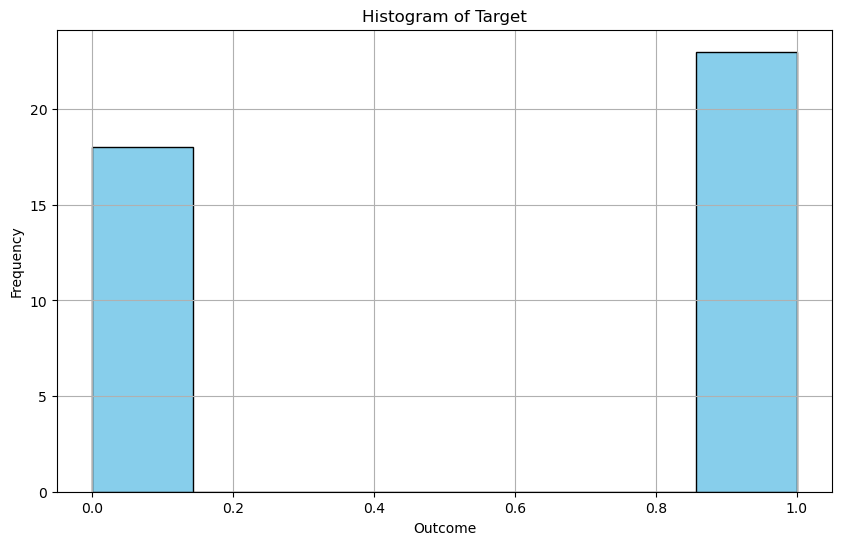

In [53]:
target_counts_sorted = outliers_dataset[target].value_counts().sort_index()

# Display the counts
print("Target Value Counts (Sorted):")
print(target_counts_sorted)

plt.figure(figsize=(10, 6))
plt.hist(outliers_dataset[target], bins='auto', color='skyblue', edgecolor='black')
plt.xlabel(target)
plt.ylabel('Frequency')
plt.title('Histogram of Target')
plt.grid(True)
plt.show()

In [ ]:
df_majority = outliers_dataset[outliers_dataset[target] == 0]


df_minority = outliers_dataset[outliers_dataset[target] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority),
                                 random_state=42)  # Add random_state for reproducibility

# Combine minority class with majority class
outliers_dataset = pd.concat([df_majority, df_minority_upsampled])

# Check the value counts of the prediction column in the downsampled dataset
print(outliers_dataset[target].value_counts())


In [ ]:
# Define the target variable 'y'
oy = outliers_dataset[target]

# Select all other columns as features 'x'
ox = outliers_dataset.drop(columns=[target])

### PCA

In [ ]:
# Perform PCA
pca = PCA()
ox_reduced = pca.fit_transform(ox)

# Define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier()

# Calculate MSE with only the intercept
mse = []
score = -1 * cross_val_score(rf_classifier, np.ones((len(ox_reduced), 1)), oy, cv=cv, scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1 * cross_val_score(rf_classifier, ox_reduced[:, :i], oy, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

# Plot cross-validation results
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Principal Components')
plt.show()

In [ ]:
#percentage of variance in the response variable explained by adding in each principal component to the model:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

In [ ]:
# Choose the desired number of principal components based on the plot
num_components = 40  # For example, choose n principal components

# Use the selected number of principal components
ox_reduced_selected = ox_reduced[:, :num_components]

## Spliting the Outlier dataset

In [ ]:
from sklearn.model_selection import train_test_split


# Split the data into training (50%), testing (30%), and out-of-sample (20%)
ox_train, ox_temp, oy_train, oy_temp = train_test_split(ox_reduced_selected, oy, test_size=0.4, random_state=100)
ox_test, ox_out_sample, oy_test, oy_out_sample = train_test_split(ox_temp, oy_temp, test_size=0.6, random_state=100)

In [ ]:
missing_values = outliers_dataset.isnull().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")


## Fitting the Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(ox_train, oy_train)

In [ ]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

In [ ]:
rf_model = RandomForestClassifier(max_depth=8,n_estimators=386)
rf_model.fit(ox_train, oy_train)

In [ ]:
oy_pred = rf_model.predict(ox_test)
oy_pred

In [ ]:
accuracy = accuracy_score(oy_test, oy_pred)
print("Accuracy:", accuracy)

## Model Evaluation

### On test data

In [ ]:
from sklearn import metrics
# Predict the labels for the test set
oy_pred = rf_model.predict(ox_test)

# Calculate accuracy
oaccuracy = accuracy_score(oy_test, oy_pred) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(oaccuracy))

In [ ]:
from sklearn.metrics import balanced_accuracy_score

# Assuming y_true and y_pred are your true and predicted labels, respectively
balanced_accuracy = balanced_accuracy_score(oy_test, oy_pred)* 100

print('Balanced Accuracy Score: {:.2f}%'.format(balanced_accuracy))

In [ ]:
oy_pred_prob_t = rf_model.predict_proba(ox_test)

def class_likelihood_ratios(oy_test, oy_pred_prob_t):
    """
    Calculate class likelihood ratios given true labels and predicted probabilities.

    Parameters:
    y_true (array-like): True labels.
    y_prob (array-like): Predicted probabilities for each class.

    Returns:
    class_lr (dict): Dictionary containing class likelihood ratios.
    """
    # Extract unique classes
    classes = np.unique(oy_test)
    
    # Initialize dictionary to store likelihood ratios
    class_lr = {}
    
    # Calculate likelihood ratios for each class
    for cls in classes:
        # Calculate class-specific likelihood ratio
        class_prob = oy_pred_prob_t[:, cls]
        class_lr[cls] = np.sum(class_prob) / (len(class_prob) - np.sum(class_prob))
    
    return class_lr

In [ ]:
# Calculate class likelihood ratios

class_lr = class_likelihood_ratios(oy_test, oy_pred_prob_t)

# Print class likelihood ratios
print("Class Likelihood Ratios:")
for cls, lr in class_lr.items():
    print(f"Class {cls}: {lr}")

In [ ]:
from sklearn.metrics import jaccard_score
jaccard_score(oy_test, oy_pred, average=None)

### On out-of-sample data

In [ ]:
from sklearn.metrics import accuracy_score

# Predict the labels for the out-of-sample set
oy_pred_out_sample = rf_model.predict(ox_out_sample)

# Calculate accuracy
oaccuracy_out_sample = accuracy_score(oy_out_sample, oy_pred_out_sample) * 100

# Print accuracy
print('Accuracy: {:.2f}%'.format(oaccuracy_out_sample))

In [ ]:
from sklearn.metrics import balanced_accuracy_score

# Assuming y_true and y_pred are your true and predicted labels, respectively
balanced_accuracy = balanced_accuracy_score(oy_out_sample, oy_pred_out_sample)* 100

print('Balanced Accuracy Score: {:.2f}%'.format(balanced_accuracy))

In [ ]:
oy_pred_prob_o = rf_model.predict_proba(ox_test)

def class_likelihood_ratios(oy_test, oy_pred_prob_o):
    """
    Calculate class likelihood ratios given true labels and predicted probabilities.

    Parameters:
    y_true (array-like): True labels.
    y_prob (array-like): Predicted probabilities for each class.

    Returns:
    class_lr (dict): Dictionary containing class likelihood ratios.
    """
    # Extract unique classes
    classes = np.unique(oy_test)
    
    # Initialize dictionary to store likelihood ratios
    class_lr = {}
    
    # Calculate likelihood ratios for each class
    for cls in classes:
        # Calculate class-specific likelihood ratio
        class_prob = oy_pred_prob_o[:, cls]
        class_lr[cls] = np.sum(class_prob) / (len(class_prob) - np.sum(class_prob))
    
    return class_lr

In [ ]:
# Calculate class likelihood ratios

class_lr = class_likelihood_ratios(oy_out_sample, oy_pred_prob_o)

# Print class likelihood ratios
print("Class Likelihood Ratios:")
for cls, lr in class_lr.items():
    print(f"Class {cls}: {lr}")

In [ ]:
from sklearn.metrics import jaccard_score
jaccard_score(oy_out_sample, oy_pred_out_sample, average=None)

## Confusion Matrix

In [ ]:
# Calculate the confusion matrix

ocm_test = confusion_matrix(oy_test, oy_pred)
ocm_out_sample = confusion_matrix(oy_out_sample, oy_pred_out_sample)

# Combine the confusion matrices
ocm = ocm_test + ocm_out_sample

# Plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=ocm).plot()


In [ ]:
# Extract indices of false positives and false negatives from the confusion matrix
false_positive_indices = [(i, j) for i in range(ocm.shape[0]) for j in range(ocm.shape[1]) if i != j and j == 1]  # False positive indices
false_negative_indices = [(i, j) for i in range(ocm.shape[0]) for j in range(ocm.shape[1]) if i != j and j == 0]  # False negative indices

# Create new DataFrame to store instances with correct and incorrect predictions
ocorrect_rows = []
oincorrect_rows = []

for index, (true_label, pred_label, out_true_label, out_pred_label) in enumerate(zip(oy_test, oy_pred, oy_out_sample, oy_pred_out_sample)):
    # Check for false positives or false negatives in the first set of predictions
    if (true_label, pred_label) in false_positive_indices or (true_label, pred_label) in false_negative_indices:
        row_data = outliers_dataset.iloc[index].tolist()
        oincorrect_rows.append(row_data + [False])
    else:
        row_data = outliers_dataset.iloc[index].tolist()
        ocorrect_rows.append(row_data + [True])

# Process remaining instances in the second set of predictions
for index, (out_true_label, out_pred_label) in enumerate(zip(oy_out_sample, oy_pred_out_sample)):
    # Check for false positives or false negatives in the second set of predictions
    if (out_true_label, out_pred_label) in false_positive_indices or (out_true_label, out_pred_label) in false_negative_indices:
        row_data = outliers_dataset.iloc[len(oy_test) + index].tolist()  # Adjust index to start from where the first loop left off
        oincorrect_rows.append(row_data + [False])
    else:
        row_data = outliers_dataset.iloc[len(oy_test) + index].tolist()  # Adjust index to start from where the first loop left off
        ocorrect_rows.append(row_data + [True])

# Create DataFrames from the collected rows
ocorrect_df = pd.DataFrame(ocorrect_rows, columns=outliers_dataset.columns.tolist() + ['correct'])
oincorrect_df = pd.DataFrame(oincorrect_rows, columns=outliers_dataset.columns.tolist() + ['correct'])

# Combine correct_df and incorrect_df into a single DataFrame
oresult_dataset = pd.concat([ocorrect_df, oincorrect_df], ignore_index=True)

# Print the resulting dataset
print(oresult_dataset)


## ROC Curve

In [ ]:
#Predict probabilities on the test set
oy_pred_proba = rf_model.predict_proba(ox_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(oy_test, oy_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Precision Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(oy_test, oy_pred_proba)

# Plot Precision-Recall curve with chance level
display = PrecisionRecallDisplay.from_predictions(
    oy_test, oy_pred_proba, name="RandomForest", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Combined Model

In [ ]:
combined_data = pd.concat([oresult_dataset, result_dataset], axis=0)

# Reset index after concatenation
combined_data.reset_index(drop=True, inplace=True)

# Display the combined dataset
print(combined_data)

In [ ]:
# Calculate accuracy
accuracy = combined_data['correct'].mean() * 100  # Convert to percentage

# Display accuracy
print("Accuracy:", accuracy, "%")